# Sarcasm Detector

## Get and Load Data

In [1]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [2]:
!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /content/SarcasmDetect.json
100% 6.06M/6.06M [00:00<00:00, 17.3MB/s]


In [3]:
!pip install contractions
!pip install textsearch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.1 MB/s eta 0:00:00


In [4]:
import contractions
from bs4 import BeautifulSoup
import re
import tqdm
import unicodedata
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
import pandas as pd

df = pd.read_json('./SarcasmDetect.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Remove all records with no headline text. Clean and split data

In [7]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 894.3+ KB


In [ ]:
random_state=42 # for reproducibility

In [ ]:
df['is_sarcastic'].value_counts() # see data distribution

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [ ]:
# Split the data.
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['is_sarcastic', 'article_link']), df['is_sarcastic'], test_size=0.3, random_state=42, stratify =df['is_sarcastic'])
X_train.shape, X_test.shape

((20033, 1), (8586, 1))

In [ ]:
from collections import Counter
Counter(y_train), Counter(y_test) #check split is correct

(Counter({0: 10489, 1: 9544}), Counter({0: 4496, 1: 4090}))

In [ ]:
X_train.head()

,headline
24819,the most dangerous beaches for shark attacks i...
11682,frustrated man doesn't know what else he can d...
2096,americans more polarized than at any time in l...
5230,megachurch threatened by new ultrachurch
7238,dog waited in this spot for a month for her fa...


In [ ]:
X_train["headline"].iloc[0]

'the most dangerous beaches for shark attacks in the u.s.'

In [ ]:
y_train

24819    0
11682    1
2096     0
5230     1
7238     0
        ..
5671     1
1230     1
17862    1
26039    1
11202    1
Name: is_sarcastic, Length: 20033, dtype: int64

(0.0, 30.0)

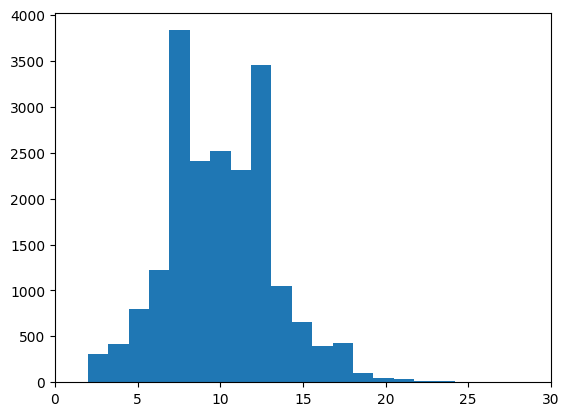

In [ ]:
plt.hist([len(doc.split()) for doc in X_train["headline"]], bins=30);
plt.xlim([0, 30])

In [ ]:
# cleaning text auxilary functions
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        norm_docs.append(doc)
    return norm_docs

In [ ]:
# Clean the data
%%time

norm_train_texts = pre_process_corpus(X_train['headline'].values)
norm_test_texts = pre_process_corpus(X_test['headline'].values)

  0%|          | 0/20033 [00:00<?, ?it/s]<ipython-input-30-c0375809da9a>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 8586/8586 [00:00<00:00, 10278.64it/s]

CPU times: user 2.69 s, sys: 19.7 ms, total: 2.71 s
Wall time: 2.72 s


## We build base line logistic regression model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(norm_train_texts)
cv_test_features = cv.transform(norm_test_texts)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

In [ ]:
%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, y_train)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

In [ ]:
# Test model on test data
print(classification_report(y_test, lr_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, lr_bow_predictions))


## We build classifier model based on transformers

In [8]:
!pip install transformers --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

Note: Run the below cell to get all the pre-processed data again in case you needed to reload the notebook after the above installation

In [1]:
import contractions
from bs4 import BeautifulSoup
import re
import tqdm
import unicodedata
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import pandas as pd

df = pd.read_json('./SarcasmDetect.json', lines=True)
df = df[df['headline'] != '']
random_state=42
# Split the data.
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['is_sarcastic', 'article_link']), df['is_sarcastic'], test_size=0.3, random_state=42, stratify =df['is_sarcastic'])

# cleaning text auxilary functions
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        norm_docs.append(doc)
    return norm_docs


norm_train_texts = pre_process_corpus(X_train['headline'].values)
norm_test_texts = pre_process_corpus(X_test['headline'].values)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
  0%|          | 0/20033 [00:00<?, ?it/s]<ipython-input-1-1811e15845ce>:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 8586/8586 [00:02<00:00, 3807.90it/s]


In [2]:
import transformers

In [3]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        # with newer versions of transformers you don't need to explicitely add CLS and SEP
        # they are automatically added by the tokenizer
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # < 500 ones

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)

    encoded = np.array([all_ids, all_masks, all_segments])

    return encoded

In [4]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig

In [5]:
MAX_SEQ_LENGTH = 30

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

sar_bert = transformers.TFRobertaModel.from_pretrained("cardiffnlp/twitter-roberta-base-irony")(inputs)
pooled_output = sar_bert[1]

# outputs = sar_bert(input_ids = inp_id, attention_mask=inp_mask, token_type_ids=inp_segment)
# pooled_output = outputs.pooler_output
# pooled_output = outputs.hidden_states[1][:, 0, :]
dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-irony were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-irony.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 30)]                 0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 30)]                 0         []                            
 er)                                                                                              
                                                                                                  
 bert_segment_ids (InputLay  [(None, 30)]                 0         []                            
 er)                                                                                          

In [6]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-irony")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [7]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               norm_train_texts,
                                                                                               max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)

Converting docs to features: 100%|██████████| 20033/20033 [00:02<00:00, 6989.28it/s]


Train Features: (20033, 30) (20033, 30) (20033, 30)


In [8]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)
model.fit([train_features_ids,
          train_features_masks,
          train_features_segments], y_train,
          validation_split=0.1,
          callbacks =[es],
          epochs=5, # run more only if needed as this takes a long time
          batch_size=10, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)


Epoch 1/5
1803/1803 [==============================] - 271s 119ms/step - loss: 0.3188 - accuracy: 0.8642 - val_loss: 0.2241 - val_accuracy: 0.9152
Epoch 2/5
1803/1803 [==============================] - 208s 115ms/step - loss: 0.1639 - accuracy: 0.9369 - val_loss: 0.2196 - val_accuracy: 0.9227
Epoch 3/5
1803/1803 [==============================] - 207s 115ms/step - loss: 0.0918 - accuracy: 0.9669 - val_loss: 0.2079 - val_accuracy: 0.9276
Epoch 4/5
1803/1803 [==============================] - 206s 114ms/step - loss: 0.0538 - accuracy: 0.9802 - val_loss: 0.2357 - val_accuracy: 0.9237
Epoch 5/5
1803/1803 [==============================] - 206s 114ms/step - loss: 0.0416 - accuracy: 0.9865 - val_loss: 0.2936 - val_accuracy: 0.9306
Epoch 5: early stopping


In [9]:
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                            norm_test_texts,
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:03<00:00, 2602.02it/s]

Test Features: (8586, 30) (8586, 30) (8586, 30)


In [10]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,
                                            test_features_segments
                                            ],
                                            verbose=0).ravel()]

# raw_predictions = model.predict([test_features_ids, test_features_masks, test_features_segments])
# # Select the prediction for the `[CLS]` token, typically at position 0
# cls_predictions = raw_predictions[:, 0, 0]
# # Convert probabilities to binary predictions
# predictions = [1 if pr > 0.5 else 0 for pr in cls_predictions]
print('Fixed predictions:', len(predictions))

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Fixed predictions: 8586
Accuracy: 92.08%
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4496
           1       0.90      0.94      0.92      4090

    accuracy                           0.92      8586
   macro avg       0.92      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586



,0,1
0,4067,429
1,251,3839


In [ ]:
len(y_test)

8586

In [ ]:
len(predictions)

257580

In [ ]:
type(model)

keras.src.engine.functional.Functional